In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# %matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [25]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
    
    AU + p + q = f
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # Make my linspace and get h
    x = np.linspace(a,b,n+1)
    y = np.linspace(c,d,n+1)
    h = x[1]-x[0]
    
    # Make T
    T = np.diag(-4*np.ones(n-1))+np.diag(np.ones(n-2),-1)+np.diag(np.ones(n-2),1)
    
    # Make A
    A = la.block_diag(*([T]*(n-1))) 
    A = (A + np.diag(np.ones((n-1)*(n-2)),-(n-1)) + np.diag(np.ones((n-1)*(n-2)),(n-1)))/(h**2)
    
    # Make p, q and f
    p = np.array([np.array([g(x[i],y[j]) if i==0 else g(x[-1],y[j]) if i==(n-2) else 0 for i in range(n-1)]/(h**2)) for j in range(1,n)])
    
    q1 = [g(x[i], y[0]) for i in range(1,n)]/h**2
    qlast = [g(x[i],y[n]) for i in range(1,n)]/h**2
    qjs = np.vstack(([np.zeros(n-1)]*(n-3)))
    
    q = np.vstack((q1,qjs,qlast))
    
    f = np.array([np.array([f(x[i],y[j]) for i in range(1,n)]) for j in range(1,n)])
    
    b = f - p - q
    
    # Solve linear system and reshape
    U = spla.spsolve(A,np.ravel(b))
    U = U.reshape(n-1,n-1)
    
#     top = np.array([g(x[i],y[0]) for i in range(n+1)])
#     bottom = np.array([g(x[i],y[n]) for i in range(n+1)])
#     left = np.array([g(x[0],y[j]) for j in range(1,n)])
#     right = np.array([g(x[n],y[j]) for j in range(1,n)])
    
#     U = np.block([[left],[U],[right]])
#     U = np.concatenate((left,U,right), axis=0)
#     U = np.vstack((top,U,bottom))
    
    return U

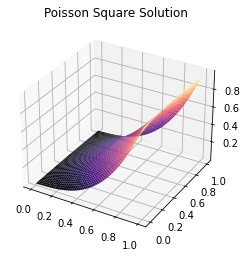

In [26]:
# Define parameters and find U
f = lambda x,y: 0
g = lambda x,y: x**3
n = 100
U = poisson_square(0,1,0,1,f,g,n)

# Plot it
x = np.linspace(0,1,n-1)
y = np.linspace(0,1,n-1)
X,Y = np.meshgrid(x,y)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X,Y,U, cmap='magma')
plt.title("Poisson Square Solution")
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

In [5]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

[[0.00012881 0.00025762 0.00038635 ... 0.00038635 0.00025762 0.00012881]
 [0.00025762 0.00051533 0.00077304 ... 0.00077304 0.00051533 0.00025762]
 [0.00038635 0.00077304 0.00116017 ... 0.00116017 0.00077304 0.00038635]
 ...
 [0.00038635 0.00077304 0.00116017 ... 0.00116017 0.00077304 0.00038635]
 [0.00025762 0.00051533 0.00077304 ... 0.00077304 0.00051533 0.00025762]
 [0.00012881 0.00025762 0.00038635 ... 0.00038635 0.00025762 0.00012881]]


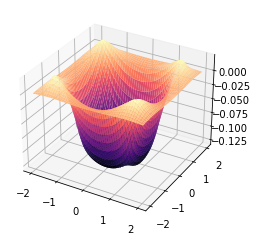

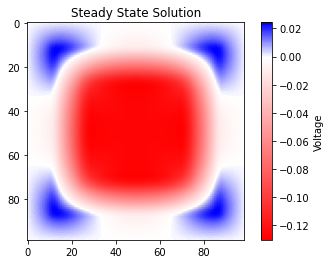

In [30]:
# Define parameters
f = lambda x,y: -1*source(x,y)
g = lambda x,y: 0
a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100

# Solve for U
U = poisson_square(-2,2,-2,2,f,g,100)
print(U)

# Plot Solution
x = np.linspace(-2,2,n-1)
y = np.linspace(-2,2,n-1)
X,Y = np.meshgrid(x,y)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X,Y,U, cmap='magma')
plt.show()

X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

# Plot Electric Potential of the 3 nested pipes
plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Voltage")
plt.title("Steady State Solution")
plt.show()